In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### preprocess wifi data

In [17]:
data = pd.DataFrame(columns=[i for i in range(24)])
for week in range(2,53):
    for file in os.listdir('AS/MSEData2/2018_week{:02d}'.format(week)):
        date = pd.to_datetime(file[:-4],infer_datetime_format=True).date()
        bydate = pd.DataFrame([0]*24, columns=[date])
        for level in range(2,7):
            raw = pd.read_csv('AS/MSEData{}/2018_week{:02d}/{}'.format(level,week,file))
            count = pd.DataFrame(raw.groupby('time')['macaddress_hash'].count())
            count['timestamp'] = pd.to_datetime(count.index,infer_datetime_format=True)
            count['hour'] = count['timestamp'].apply(lambda x: x.hour)
            count = pd.DataFrame(count.groupby('hour')['macaddress_hash'].max())
            bylv = pd.DataFrame([0]*24,columns=['bylv'])
            bylv['bylv'] = count['macaddress_hash'] + bylv['bylv']
            bydate[date] = bydate[date] + bylv.interpolate('nearest').fillna(method = 'bfill')['bylv']
        data = pd.concat([data,bydate.T],sort=True)

In [ ]:
data.to_csv('AS2_2018WIFI.csv')

### read data

In [3]:
wifiR = pd.read_csv('AS2_2018WIFI.csv',index_col=0)
wifi = pd.DataFrame()
for i in wifiR.index:
    byDay = wifiR.loc[i,:]
    byDay.index = i + ' ' + byDay.index
    wifi = pd.concat([wifi,byDay])
wifi.columns = ['wifi']

In [4]:
elecR = pd.read_csv('AS22018.csv',index_col=0)
elec = pd.DataFrame()
for i in elecR.index:
    byDay = elecR.loc[i,:]
    byDay.index = i + ' ' + byDay.index
    elec = pd.concat([elec,byDay])
elec.columns = ['elec']

In [5]:
btuR = pd.read_csv('AS2_BTU_2018.csv',index_col=0)
btu = pd.DataFrame()
for i in btuR.index:
    byDay = btuR.loc[i,:]
    byDay.index = i + ' ' + byDay.index
    btu = pd.concat([btu,byDay])
btu.columns = ['btu']

In [42]:
together = wifi.join(elec,how = 'left')
together = together.join(btu,how = 'left')
together['time'] = together.index
together['time'] = together['time'].apply(lambda x: x if len(x)>12 else x[:10]+' 0'+x[-1])
together.index = pd.to_datetime(together['time'],format='%Y-%m-%d %H')

In [43]:
from pyepw.epw import EPW
epw = EPW()
epw.read(r"SGP_SINGAPORE-CHANGI-AP_486980_18-17.epw")
weather = []
for wd in epw.weatherdata:
    if wd.year == 2018:
        weather.append([wd.year, wd.month, wd.day, wd.hour, wd.dry_bulb_temperature])
    else:
        break
weather = pd.DataFrame(weather,columns=['year','month','day','hour','temp'])
weather.index = pd.to_datetime(weather[['year','month','day','hour']])
together = together.join(weather['temp'],how = 'left')
together.head()

,wifi,elec,btu,time,temp
time,,,,,
2018-01-08 00:00:00,16.0,72.34,0.0,2018-01-08 00,26.0
2018-01-08 01:00:00,16.0,70.72,3.0,2018-01-08 01,26.0
2018-01-08 02:00:00,15.0,71.85,0.0,2018-01-08 02,25.5
2018-01-08 03:00:00,16.0,72.41,0.0,2018-01-08 03,25.0
2018-01-08 04:00:00,20.0,71.81,0.0,2018-01-08 04,25.0


### exploratory analysis

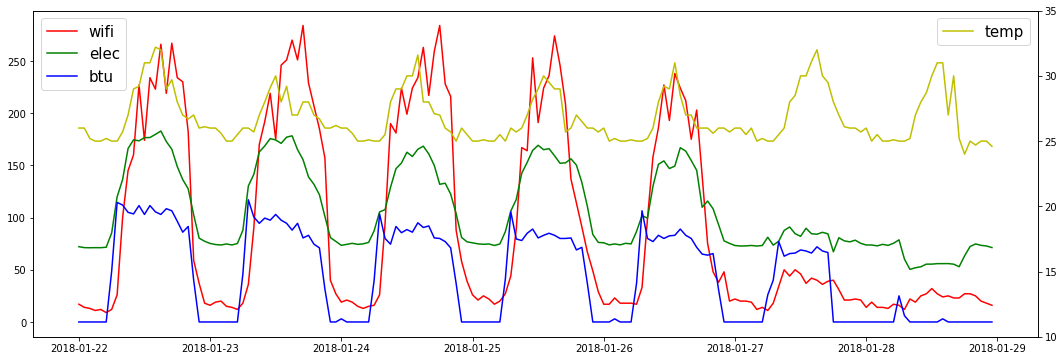

In [69]:
start = 24*14
end = 24*21
fig, ax1 = plt.subplots(figsize = [18,6])
ax1.plot(together['wifi'][start:end],label = 'wifi',c='r')
ax1.plot(together['elec'][start:end],label = 'elec',c='g')
ax1.plot(together['btu'][start:end],label = 'btu',c='b')
ax1.legend(fontsize = 15,loc='upper left')
ax2 = ax1.twinx()
ax2.plot(together['temp'][start:end],label = 'temp',c='y')
ax2.set_ylim(10,35)
ax2.legend(fontsize = 15,loc='upper right')
plt.show()

In [70]:
print(np.corrcoef(together['wifi'],together['elec'])[1][0])
print(np.corrcoef(together['wifi'],together['btu'])[1][0])
print(np.corrcoef(together['elec'],together['btu'])[1][0])

0.862921076049
0.699332493982
0.849678371102


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as CH
# for d in [wifiR, elecR, btuR]:
#     [bestK, bestCH] = [0,0]
#     for k in range(2,8):
#         kmeans = KMeans(n_clusters=k, random_state=0).fit(d)
#         if CH(d,kmeans.labels_) > bestCH:
#             [bestK, bestCH] = [k,CH(d,kmeans.labels_)]
#     d['label'] = KMeans(n_clusters=bestK, random_state=0).fit(d).labels_
    d['label'] = KMeans(n_clusters=3, random_state=0).fit(d).labels_

In [ ]:
# to unify the labels
forElec = {0:2,2:0,1:1}
elecR['label'] = elecR['label'].apply(lambda x:forElec[x])
forBtu = {0:1,1:0,2:2}
btuR['label'] = btuR['label'].apply(lambda x:forBtu[x])

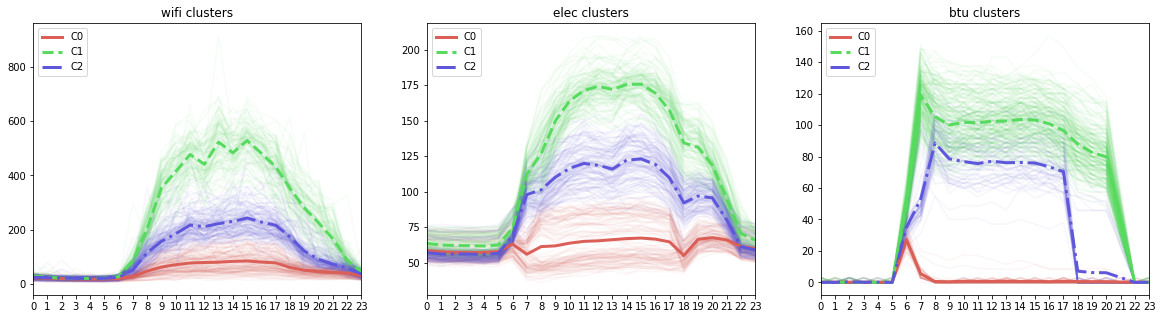

In [20]:
import seaborn as sns
fig = plt.figure(figsize=(20,5))
names = ['wifi','elec','btu']
num=1
for d in [wifiR, elecR, btuR]:
    labels = list(np.unique(d['label']))
    lines = ['-', '--', '-.', ':']
    color_palette = sns.color_palette('hls', len(labels))
    plt.subplot(1, 3, num)
    for i in labels:
        plt.plot(d[d['label']==i].iloc[:,:24].T,color = color_palette[labels.index(i)],alpha = .05)
    for i in labels:
        plt.plot(np.mean(d[d['label']==i].iloc[:,:24]).T,color = color_palette[labels.index(i)],
                 linestyle=lines[i%4],label='C'+str(i),linewidth = 3)
    plt.title('{} clusters'.format(names[num-1]))
    num += 1
    plt.legend(loc='upper left')
    plt.xlim(0,23)
plt.show()

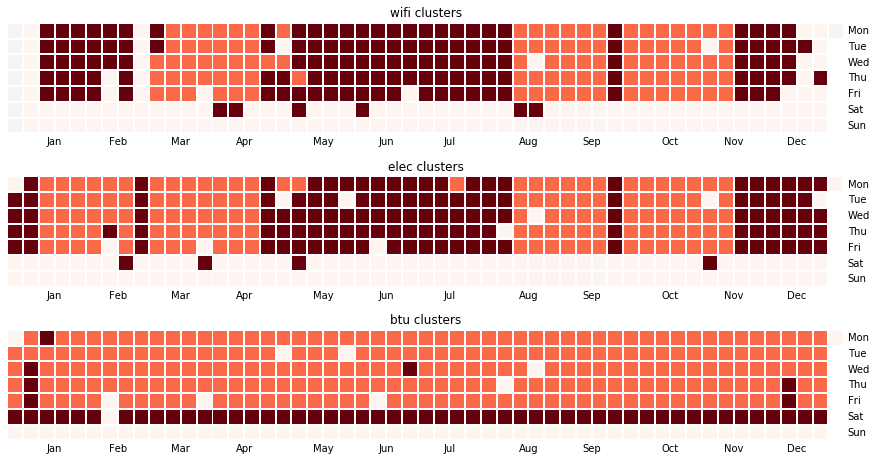

In [21]:
import calmap
fig = plt.figure(figsize=(15,8))
num=1
for d in [wifiR, elecR, btuR]:
    d.index = pd.to_datetime(d.index,infer_datetime_format=True)
    label = d['label']
    plt.subplot(3, 1, num)
    plt.title('{} clusters'.format(names[num-1]))
    num += 1
    calmap.yearplot(label, year=2018)
plt.show()

### wifi matches electricity quite well, while cooling consumption follows another pattern

## for discussion
#### Literature: most use wifi to detect/predict occupancy, some use OCC as input to BEM

- how to process wifi for occupancy
- potential use for spatial temporal data mining
- how does occupants influence building consumption (multi buildings)
- does wifi help prediction?
- a framework to predict total building consumption (HVAC and others separately)